In [1]:
import os
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import utils
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import pandas as pd

In [2]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data,rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps=pitch_factor)

In [3]:
def extract_features(file_path, sr=22050, n_mfcc=13):
    audio, _ = librosa.load(file_path, sr=sr)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs, axis=1)
    return mfccs_mean

In [4]:
data_directory = 'final_data/'

In [5]:
augmented_features = []
augmented_labels = []
data_aug = [noise,stretch,shift,pitch]
for folder_name in os.listdir(data_directory):
    folder_path = os.path.join(data_directory, folder_name)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path) and file_name.endswith('.wav'):
            original_features = extract_features(file_path)
            augmented_features.append(original_features)
            augmented_labels.append(folder_name)

            audio, sr = librosa.load(file_path, sr=22050)
            for i in data_aug:
              x=None
              if i==pitch :
                x=i(audio,sr,0.7)
              else:
                x=i(audio)
              augmented_features.append(np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=13), axis=1))
              augmented_labels.append(folder_name)
            augmented_features.append(np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13), axis=1))
            augmented_labels.append(folder_name)

In [6]:
data = {'features': augmented_features, 'label': augmented_labels}
df = pd.DataFrame(data).sample(frac=1).reset_index(drop=True)

print(df.head())

                                            features  label
0  [-463.5575, 66.93958, -4.8772373, 2.278421, 0....  angry
1  [-234.33563, 66.25152, -43.223396, 23.40519, -...  angry
2  [-139.75055, 80.58764, -16.367262, -6.402271, ...  happy
3  [-359.46838, -4.2040706, -9.773112, 12.420343,...  angry
4  [-308.3432, 94.00077, 7.473597, 27.409563, 7.5...    sad


In [7]:
df['label'].unique()

array(['angry', 'happy', 'sad', 'fear', 'neutral'], dtype=object)

In [9]:
d=dict.fromkeys(df.label.unique().tolist(),0)
for i in df.label:
  d[i]+=1

d

{'angry': 294, 'happy': 246, 'sad': 294, 'fear': 168, 'neutral': 168}

In [15]:
np.array(df['label'].unique())

array(['angry', 'happy', 'sad', 'fear', 'neutral'], dtype=object)

In [16]:
x = [i for i in df['features']]
x = np.array(x)
x = np.expand_dims(x,-1)

In [19]:
en = LabelEncoder()
y = en.fit_transform(df[['label']])
pd.Series(y).unique()

c:\Users\thanu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 2, 4, 1, 3])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [21]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

lstm= Sequential([
    LSTM(256, return_sequences=False ,input_shape =(13,1)),
    Dense(128,activation='relu'),
    Dropout(0,2),
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(5,activation='softmax'),
])
lstm.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
lstm.summary()

c:\Users\thanu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,669 (1.17 MB)

 Trainable params: 305,669 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
lstm_ = lstm.fit(X_train,y_train,validation_split=0.3,epochs=20,batch_size=4)

Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.3601 - loss: 1.4779 - val_accuracy: 0.4106 - val_loss: 1.3621
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4143 - loss: 1.3310 - val_accuracy: 0.4106 - val_loss: 1.3946
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4470 - loss: 1.2811 - val_accuracy: 0.5081 - val_loss: 1.3859
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5251 - loss: 1.2023 - val_accuracy: 0.5000 - val_loss: 1.2985
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5826 - loss: 1.0522 - val_accuracy: 0.5325 - val_loss: 1.1720
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6071 - loss: 1.0047 - val_accuracy: 0.6057 - val_loss: 0.9854
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6186 - loss: 0.9116 - val_accuracy: 0.6138 - val_loss: 0.9529
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7034 - loss: 0.7928 - val_accu

In [31]:
enc=OneHotEncoder()
blstm_y=enc.fit_transform(df[['label']]).toarray()          

In [32]:
X_train, X_test, y_train, y_test = train_test_split(x, blstm_y, test_size=0.33, random_state=42)

In [33]:
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense

bdlstm = Sequential()
bdlstm.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(13,1)))
bdlstm.add(Dropout(0.2))
bdlstm.add(Bidirectional(LSTM(units=64)))
bdlstm.add(Dense(units=5, activation='softmax'))

# Compile the model
bdlstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
bdlstm_=bdlstm.fit(X_train, y_train, epochs=20, batch_size=4, validation_data=(X_test, y_test))

Epoch 1/20


c:\Users\thanu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.3640 - loss: 1.4893 - val_accuracy: 0.5116 - val_loss: 1.2444
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5462 - loss: 1.1543 - val_accuracy: 0.5840 - val_loss: 1.0710
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6072 - loss: 0.9670 - val_accuracy: 0.5943 - val_loss: 1.0006
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6796 - loss: 0.8148 - val_accuracy: 0.6537 - val_loss: 0.9203
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7272 - loss: 0.7550 - val_accuracy: 0.7494 - val_loss: 0.6805
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8071 - loss: 0.5344 - val_accuracy: 0.7959 - val_loss: 0.5735
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8528 - loss: 0.4079 - val_accuracy: 0.8243 - val_loss: 0.5390
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8986 - loss: 0.3196 - val_accuracy: 0.85

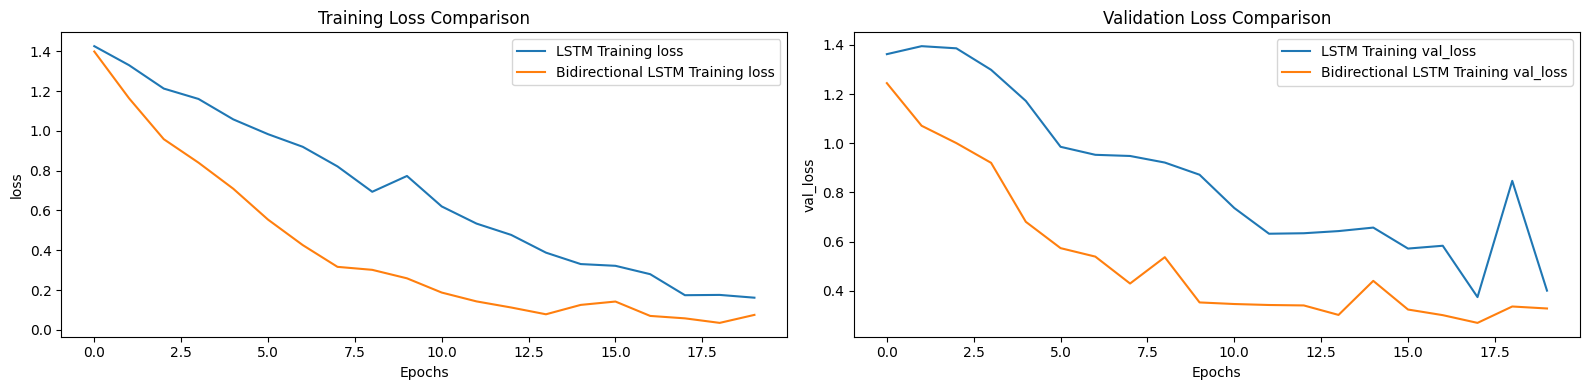

In [34]:
def plot_metrics(metric, title):
    plt.plot(lstm_.history[metric], label='LSTM Training ' + metric)
    plt.plot(bdlstm_.history[metric], label='Bidirectional LSTM Training ' + metric)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

fig, axs = plt.subplots(1, 2, figsize=(16,4))
plt.subplot(1, 2, 1)
plot_metrics('loss', 'Training Loss Comparison')
plt.subplot(1, 2, 2)
plot_metrics('val_loss', 'Validation Loss Comparison')
plt.tight_layout()
plt.show()

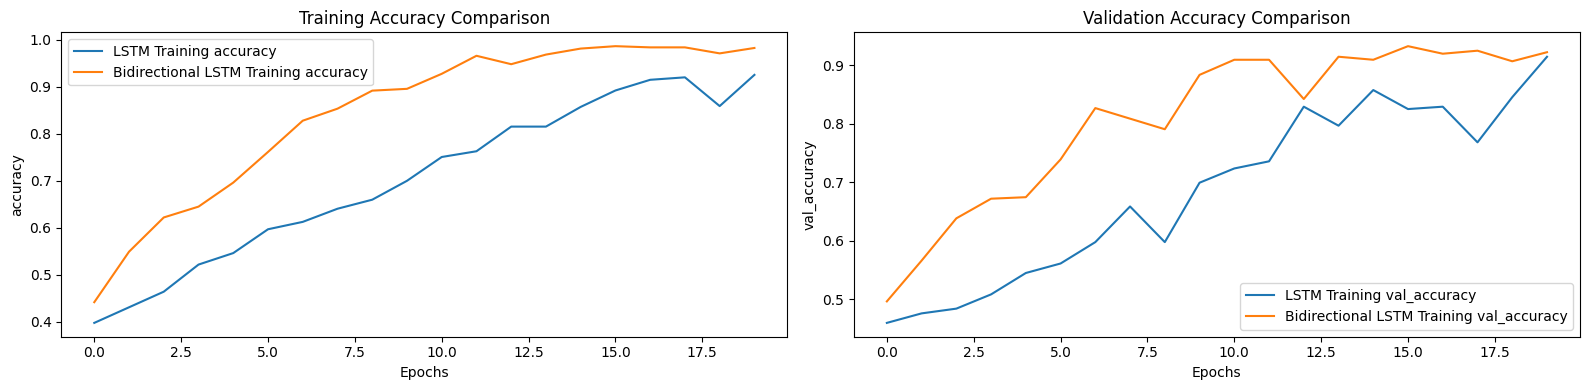

In [21]:
def plot_accuracy(metric, title):
    plt.plot(lstm_.history[metric], label='LSTM Training ' + metric)
    plt.plot(bdlstm_.history[metric], label='Bidirectional LSTM Training ' + metric)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

fig, axs = plt.subplots(1, 2, figsize=(16, 4))
plt.subplot(1, 2, 1)
plot_accuracy('accuracy', 'Training Accuracy Comparison')
plt.subplot(1, 2, 2)
plot_accuracy('val_accuracy', 'Validation Accuracy Comparison')
plt.tight_layout()
plt.show()

In [35]:
from sklearn.metrics import classification_report

class_names = ['angry', 'fear', 'happy', 'neutral', 'sad']

lstm_preds = lstm.predict(X_test)
bdlstm_preds = bdlstm.predict(X_test)

y_true = np.argmax(y_test, axis=1)

lstm_report = classification_report(y_true, lstm_preds.argmax(axis=1), target_names=class_names)
bdlstm_report = classification_report(y_true, bdlstm_preds.argmax(axis=1), target_names=class_names)

print("\n\t\t\tLSTM Classification Report:")
print(lstm_report)

print("\n\t\t\tBidirectional LSTM Classification Report:")
print(bdlstm_report)



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step

			LSTM Classification Report:
              precision    recall  f1-score   support

       angry       0.77      0.91      0.84        93
        fear       0.94      0.86      0.90        59
       happy       0.97      0.83      0.90        78
     neutral       0.91      0.76      0.83        66
         sad       0.86      0.96      0.91        91

    accuracy                           0.87       387
   macro avg       0.89      0.87      0.87       387
weighted avg       0.88      0.87      0.87       387


			Bidirectional LSTM Classification Report:
              precision    recall  f1-score   support

       angry       0.83      0.92      0.87        93
        fear       0.93      0.88      0.90        59
       happy       1.00      0.81      0.89        78
     neutral       0.87      0.92      0.90        66
         sad       0.95      0.98      0.96        91

    accuracy               

In [36]:
# Best Model
bdlstm.save('emotionclassifier.h5')